Cell 1: Setup and Data Loading

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from google.colab import drive
from PIL import Image

# Mount Google Drive to access your files

# Load the Olivetti faces dataset
# This dataset has 40 classes (40 people), with 10 images each.
olivetti = fetch_olivetti_faces()
X = olivetti.data  # Image data (flattened)
y = olivetti.target # Labels (0-39)

# Get dataset dimensions
n_samples, n_features = X.shape
n_classes = len(np.unique(y))
image_shape = (64, 64)

print(f"Dataset loaded successfully! ✨")
print(f"Number of samples (images): {n_samples}")
print(f"Number of features (pixels) per image: {n_features}")
print(f"Number of classes (people): {n_classes}")
print(f"Shape of data matrix X: {X.shape}")
print(f"Shape of target vector y: {y.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded successfully! ✨
Number of samples (images): 400
Number of features (pixels) per image: 4096
Number of classes (people): 40
Shape of data matrix X: (400, 4096)
Shape of target vector y: (400,)


Cell 2: Step 1 - Compute Mean Vectors

In [3]:
# Step 1: Compute Mean Vectors

# Overall mean vector
mean_overall = np.mean(X, axis=0)
print(f"Shape of overall mean vector: {mean_overall.shape}")

# Per-class mean vectors
mean_vectors = []
for cl in range(n_classes):
    # Select all samples belonging to the current class 'cl'
    class_samples = X[y == cl]
    # Compute the mean of these samples
    mean_vectors.append(np.mean(class_samples, axis=0))

# Convert list of mean vectors to a NumPy array
mean_vectors = np.array(mean_vectors)
print(f"Shape of the class means matrix (one row per class): {mean_vectors.shape}")

Shape of overall mean vector: (4096,)
Shape of the class means matrix (one row per class): (40, 4096)


Step 2 - Calculate Within-Class Scatter Matrix (S_W)

In [4]:
# Step 2: Calculate the Within-Class Scatter Matrix (S_W)

# Initialize S_W with zeros. It must be a square matrix of size (n_features x n_features)
S_W = np.zeros((n_features, n_features))

# Loop through each class
for cl, mv in enumerate(mean_vectors):
    # Initialize the scatter matrix for the current class
    class_scatter_matrix = np.zeros((n_features, n_features))
    # Loop through each sample in the current class
    for row in X[y == cl]:
        # Reshape row and mean vector to column vectors for matrix multiplication
        row, mv = row.reshape(n_features, 1), mv.reshape(n_features, 1)
        # Add the scatter of the current sample
        class_scatter_matrix += (row - mv).dot((row - mv).T)
    # Add the class's scatter matrix to the overall S_W
    S_W += class_scatter_matrix

print(f"Shape of the Within-Class Scatter Matrix S_W: {S_W.shape}")

Shape of the Within-Class Scatter Matrix S_W: (4096, 4096)


Step 3 - Calculate Between-Class Scatter Matrix (S_B)

In [5]:
# Step 3: Calculate the Between-Class Scatter Matrix (S_B)

# Initialize S_B with zeros
S_B = np.zeros((n_features, n_features))
mean_overall = mean_overall.reshape(n_features, 1) # Reshape for calculations

# Loop through each class
for i, mv in enumerate(mean_vectors):
    # Number of samples in the current class
    n_c = X[y == i].shape[0]
    # Reshape the class mean vector
    mv = mv.reshape(n_features, 1)
    # Calculate the scatter for this class and add to S_B
    S_B += n_c * (mv - mean_overall).dot((mv - mean_overall).T)

print(f"Shape of the Between-Class Scatter Matrix S_B: {S_B.shape}")

Shape of the Between-Class Scatter Matrix S_B: (4096, 4096)


Step 4 & 5 - Solve Eigenvalue Problem & Select Components

In [6]:
# Step 4 & 5: Solve Eigenvalue Problem and Select Components

# To avoid singularity, we add a small value (regularization) to the diagonal of S_W
# before taking the inverse.
epsilon = 1e-4
S_W_reg = S_W + np.eye(n_features) * epsilon
inv_S_W = np.linalg.inv(S_W_reg)

# Solve the generalized eigenvalue problem
eig_vals, eig_vecs = np.linalg.eig(inv_S_W.dot(S_B))

# The eigenvectors are in the columns of eig_vecs. We need to handle complex numbers
# that arise from numerical instabilities. We take the real part.
eig_vecs = eig_vecs.real

# Pair eigenvalues with their corresponding eigenvectors
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]
# Sort the pairs in descending order of eigenvalues
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

print("Top 5 Eigenvalues:")
for i in range(5):
    print(f"  {i+1}: {eig_pairs[i][0]:.4f}")

# Select the top k=C-1 eigenvectors to create the transformation matrix W
k = n_classes - 1
W = np.hstack([eig_pairs[i][1].reshape(n_features, 1) for i in range(k)])

print(f"\nShape of original eigenvector matrix: {eig_vecs.shape}")
print(f"Shape of our new transformation matrix W: {W.shape}")

Top 5 Eigenvalues:
  1: 1932467.7728
  2: 1418855.2082
  3: 1085606.4144
  4: 960124.5347
  5: 674141.1949

Shape of original eigenvector matrix: (4096, 4096)
Shape of our new transformation matrix W: (4096, 39)


Step 6 - Project Data onto New Feature Space
Finally, we use our transformation matrix W to project the original 4096-dimensional data onto the new 39-dimensional feature space.

X_LDA=X
cdotW


Original data shape: (400, 4096)
Shape of transformation matrix W: (4096, 39)
Transformed (projected) data shape: (400, 39) 👍


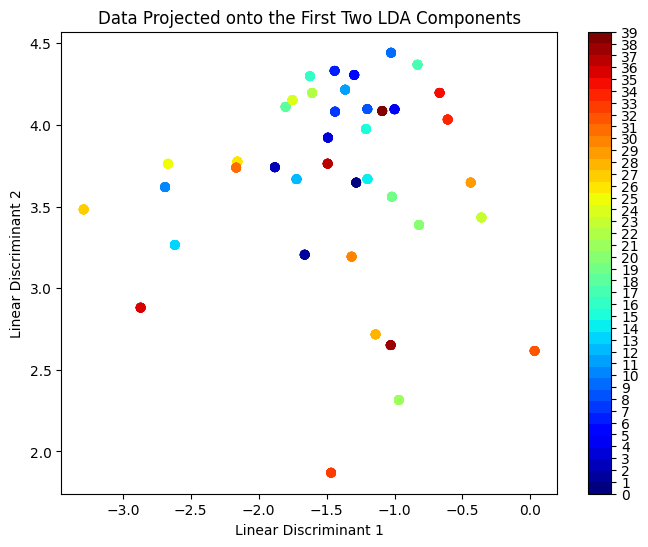

In [7]:
# Step 6: Project the data onto the new subspace
X_lda = X.dot(W)

print(f"Original data shape: {X.shape}")
print(f"Shape of transformation matrix W: {W.shape}")
print(f"Transformed (projected) data shape: {X_lda.shape} 👍")

# Let's visualize the projected data for the first two components
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap=plt.get_cmap('jet', n_classes))
plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.title('Data Projected onto the First Two LDA Components')
plt.colorbar(scatter, ticks=range(n_classes))
plt.show()

Apply LDA to a New Image from Drive

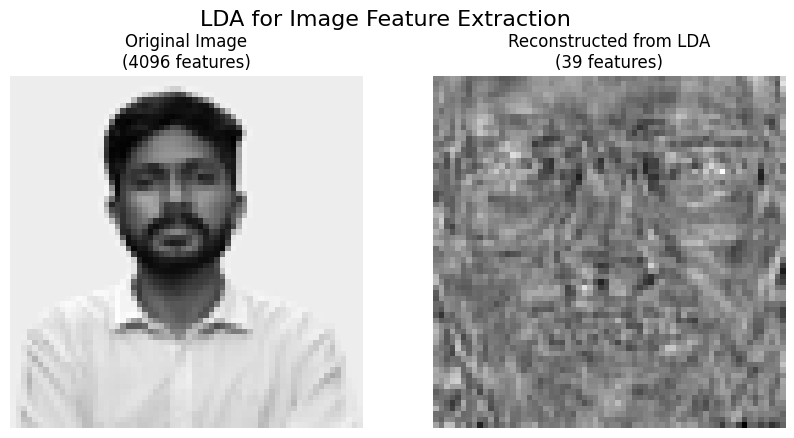

In [ ]:
# --- IMPORTANT: Change this path to an image file in your Google Drive ---
image_path = 'Rishad design.jpg' #<-- CHANGE THIS

try:
    # Load the image using PIL
    new_image = Image.open(image_path).convert('L') # Convert to grayscale

    # Preprocess the image to match the dataset
    new_image = new_image.resize(image_shape) # Resize to 64x64
    new_image_array = np.array(new_image)

    # Flatten the image and normalize pixel values to be between 0 and 1
    image_vector = new_image_array.flatten() / 255.0

    # Project the image vector onto the LDA space (the "compression")
    image_lda_compressed = image_vector.dot(W)

    # Reconstruct the image from the compressed representation
    # Note: LDA is not designed for perfect reconstruction like PCA.
    # We project it back using the transpose of W.
    reconstructed_vector = image_lda_compressed.dot(W.T)
    reconstructed_image = reconstructed_vector.reshape(image_shape)

    # --- Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(new_image_array, cmap='gray')
    axes[0].set_title(f"Original Image\n(4096 features)")
    axes[0].axis('off')

    axes[1].imshow(reconstructed_image, cmap='gray')
    axes[1].set_title(f"Reconstructed from LDA\n({k} features)")
    axes[1].axis('off')

    plt.suptitle("LDA for Image Feature Extraction", fontsize=16)
    plt.show()

except FileNotFoundError:
    print(f"🚨 Error: File not found at '{image_path}'")
    print("Please upload an image to your Google Drive and update the path.")

# **new code**

Image loaded successfully with dimensions: (300, 300) (Height, Width)


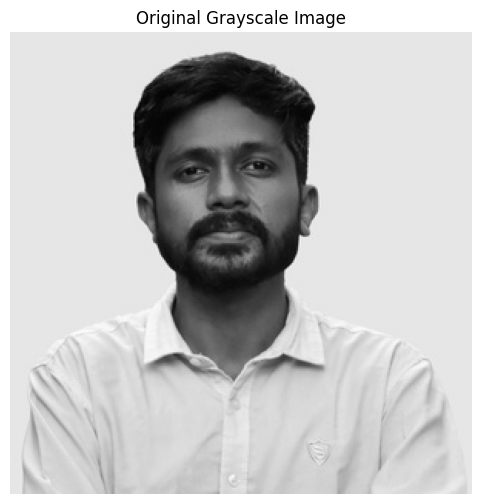


Data prepared for LDA.
Shape of data matrix X (Samples, Features): (300, 300)
Number of generated class labels (y): 300

Applying LDA to reduce dimensions from 300 to 5...
Dimensionality reduction complete. ✅
Shape of the new, reduced data matrix: (300, 5)

Image reconstructed from the low-dimensional data.
Shape of reconstructed data: (300, 300)


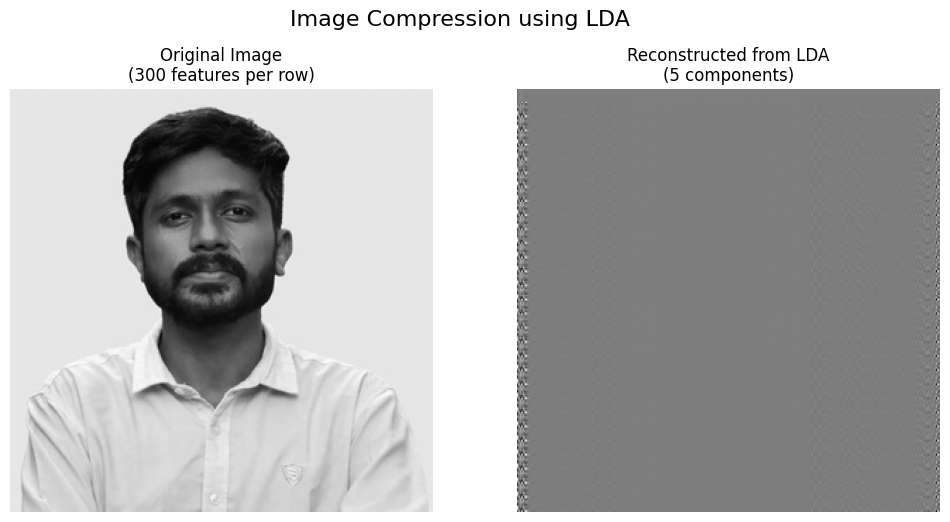

In [20]:
# Import necessary libraries
import numpy as np  # For numerical operations, especially with arrays (matrices)
import matplotlib.pyplot as plt  # For plotting and displaying images
from PIL import Image  # Python Imaging Library (Pillow) for opening, manipulating, and saving many different image file formats
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # The LDA model from scikit-learn

# --- Step 1: Load and Display the Original Image ---

# IMPORTANT: Change this path to the location of your image in Google Drive.
# The path should point directly to your image file.
image_path = '/content/drive/MyDrive/Lab/Rishad-pic.jpg'

# Use a try-except block for robust error handling. This prevents the script
# from crashing if the image file is not found at the specified path.
try:
    # Open the image file using the PIL library.
    img = Image.open(image_path)

    # Convert the image to grayscale using the '.convert('L')' method.
    # 'L' stands for Luminance. This simplifies the problem by removing color,
    # reducing the data from 3 channels (R, G, B) to a single channel.
    img_gray = img.convert('L')

    # Convert the PIL grayscale image object into a NumPy array.
    # We specify 'dtype=float' so that we can perform mathematical operations on the pixel values.
    gray_image = np.array(img_gray, dtype=float)

except FileNotFoundError:
    # This block executes if the file is not found at the 'image_path'.
    print(f"🚨 Error: File not found at '{image_path}'")
    print("Please make sure the file is uploaded and the path is correct.")
    # Create a black placeholder image to allow the rest of the script to run without crashing.
    gray_image = np.zeros((100, 100))

# Retrieve the dimensions (height, width) of the loaded image matrix.
original_shape = gray_image.shape
print(f"Image loaded successfully with dimensions: {original_shape} (Height, Width)")

# --- Display the original image for visual confirmation ---
plt.figure(figsize=(6, 6))  # Create a figure to draw on with a specific size
plt.imshow(gray_image, cmap='gray')  # Display the NumPy array as an image, specifying a grayscale colormap
plt.title("Original Grayscale Image")  # Add a title to the plot
plt.axis('off')  # Turn off the x and y axes for a cleaner look
plt.show()  # Render and display the plot

# --- Step 2: Prepare Data for LDA ---

# LDA is a SUPERVISED learning algorithm, meaning it requires labeled data (X and y) to learn.
# Since a single image doesn't have inherent classes, we must create artificial or "pseudo" labels.
# Here, we make an assumption: we treat each ROW of pixels as a separate data sample.
# Then, we group these rows into a fixed number of classes to train the LDA model.

# 'X' is our data matrix. Each row is a sample, and each column is a feature (a pixel's intensity).
X = gray_image
# 'n_classes' is the number of artificial groups we want to create for our rows.
n_classes = 10
# 'y' is our label vector. We generate a label for each row.
# The modulo operator '%' creates a repeating sequence of labels (0, 1, 2, ..., 9, 0, 1, ...).
# This assigns each row to one of the 10 classes.
y = np.array([i % n_classes for i in range(X.shape[0])])

print(f"\nData prepared for LDA.")
print(f"Shape of data matrix X (Samples, Features): {X.shape}")
print(f"Number of generated class labels (y): {len(y)}")

# --- Step 3: Apply LDA for Dimensionality Reduction ---

# Our goal is to reduce the number of features (the number of pixels in each row).
# 'n_components' is the target number of dimensions we want to reduce to.
# For LDA, the number of components cannot be more than n_classes - 1.
n_components = 5
print(f"\nApplying LDA to reduce dimensions from {X.shape[1]} to {n_components}...")

# Create an instance of the LinearDiscriminantAnalysis model.
# We specify the desired number of dimensions for the output.
lda = LinearDiscriminantAnalysis(n_components=n_components)

# The .fit_transform() method first learns the optimal projection directions from the
# data (X) and labels (y) (the 'fit' part), and then projects the data onto this new,
# lower-dimensional space (the 'transform' part).
X_reduced = lda.fit_transform(X, y)

print(f"Dimensionality reduction complete. ✅")
print(f"Shape of the new, reduced data matrix: {X_reduced.shape}")

# --- Step 4: Reconstruct the Image from the Reduced Data ---

# To see what information was preserved, we project the low-dimensional data
# back into the original high-dimensional pixel space. This is the reconstruction step.
# NOTE: LDA in scikit-learn does not have a built-in '.inverse_transform()' method like PCA.
# We must perform this step manually.

# The transformation matrix (containing the discriminant axes or eigenvectors)
# is stored in the '.scalings_' attribute of the fitted LDA object.
# This matrix has a shape of (n_features, max_components), where max_components is n_classes - 1.
# We must slice it to get only the 'n_components' we actually used for the transformation.
W = lda.scalings_[:, :n_components]

# We perform matrix multiplication (@) between our reduced data and the transpose (.T)
# of our transformation matrix 'W' to project it back.
# Shape check: (n_samples, n_components) @ (n_components, n_features) -> (n_samples, n_features)
X_reconstructed = X_reduced @ W.T

# After reconstruction, the pixel values are no longer in the standard 0-255 or 0-1 range.
# We must normalize the entire matrix to a 0-1 range for correct color mapping during display.
X_reconstructed = (X_reconstructed - X_reconstructed.min()) / (X_reconstructed.max() - X_reconstructed.min())

print("\nImage reconstructed from the low-dimensional data.")
print(f"Shape of reconstructed data: {X_reconstructed.shape}")

# --- Step 5: Display the Original vs. Compressed Images ---

# Create a figure with two subplots side-by-side to compare the images.
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the Original Image on the first subplot (axes[0])
axes[0].imshow(gray_image, cmap="gray")
axes[0].set_title(f"Original Image\n({original_shape[1]} features per row)")
axes[0].axis("off")

# Display the Reconstructed Image on the second subplot (axes[1])
axes[1].imshow(X_reconstructed, cmap="gray")
axes[1].set_title(f"Reconstructed from LDA\n({n_components} components)")
axes[1].axis("off")

# Add a main title to the entire figure.
plt.suptitle("Image Compression using LDA", fontsize=16)
plt.show()  # Display the final comparison plot.